# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]()<br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


In [1]:
# Decide if you want to run a region or the country
area = "COUNTRY"
# area = "Copperbelt" # Regions = Central, Copperbelt, Eastern

### Import necessary modules

In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
from osgeo import ogr, gdal, osr
import fiona
from rasterstats import zonal_stats
import rasterio
import rasterio.fill
from geojson import Feature, Point, FeatureCollection
import h3 as h3

# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [3]:
# import ipywidgets as widgets
import tkinter as tk
from tkinter import filedialog, messagebox
import datetime
import warnings
import scipy.spatial
warnings.filterwarnings('ignore')

import seaborn as sns

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters, spatialjoinvectors

### Define directories and dataset names

In [5]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs/"

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

# Part 1. Create base grid with H3

COUNTRY
EPSG:4326


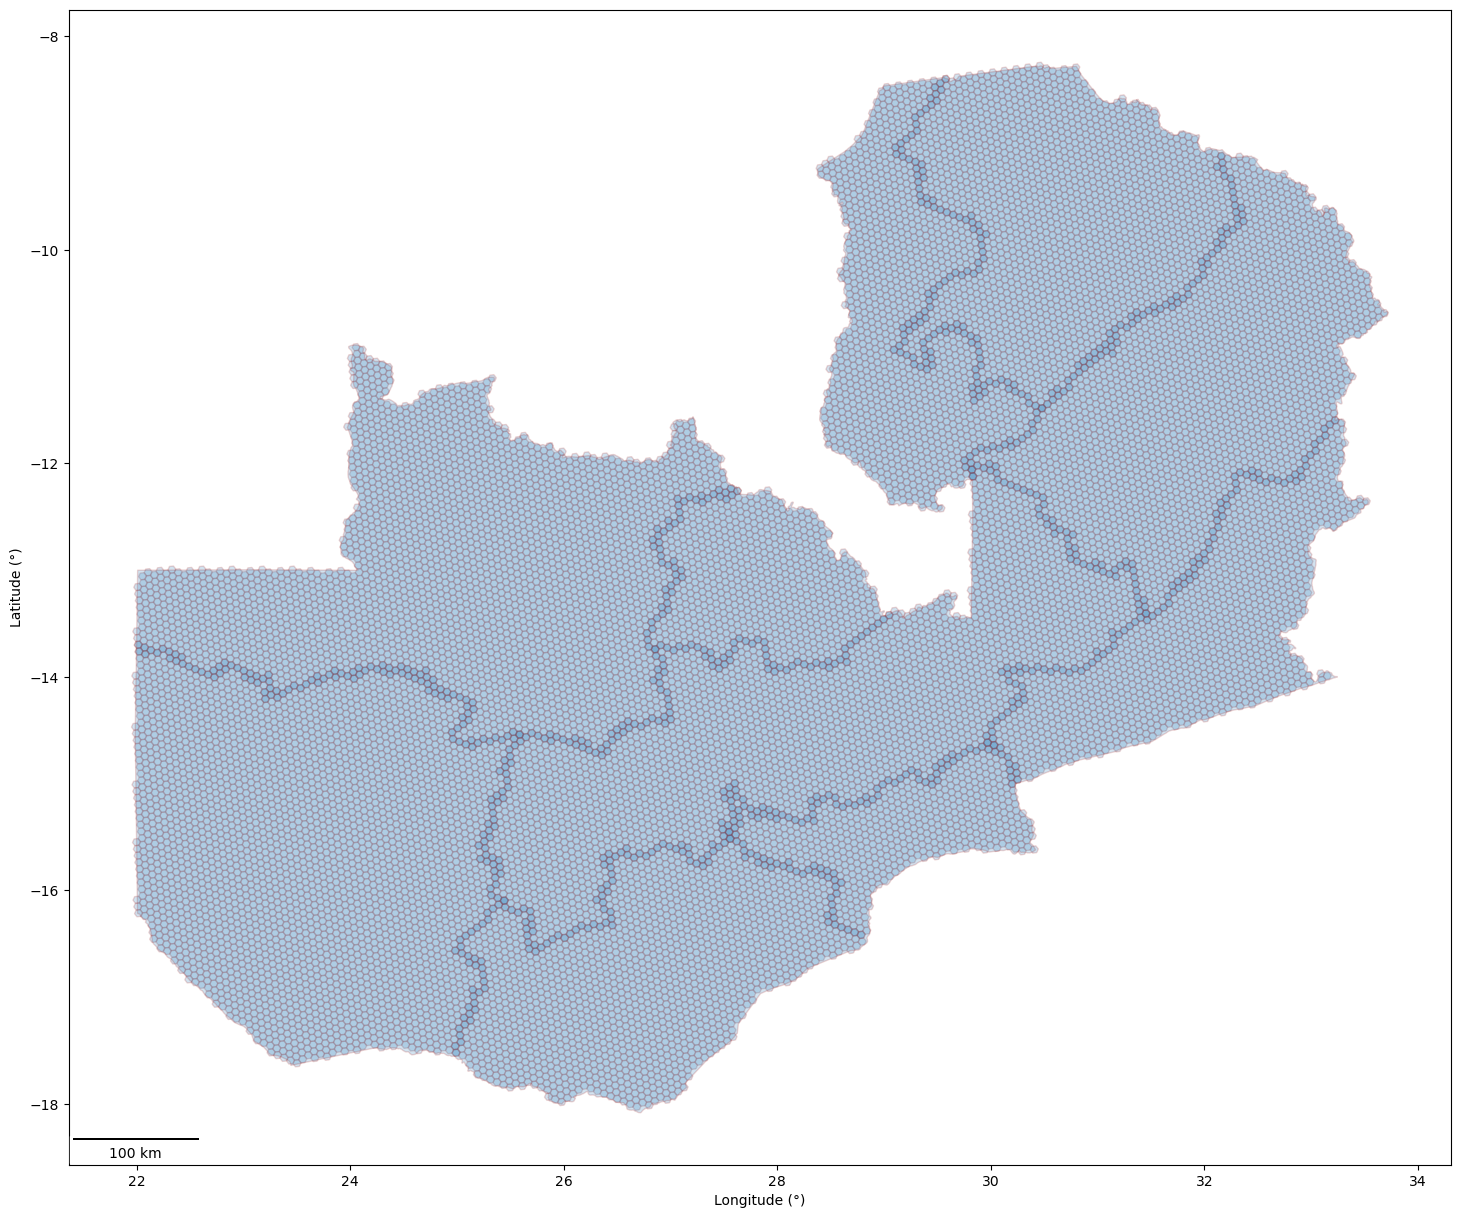

In [7]:
%run BaseGridHex.ipynb

# Part 2. Extract GIS-based attributes

## Extract raster values to hexagons

##### Once done with rasters run this cell

In [8]:
# grid = finalizing_rasters(out_path, grid, crs_proj)

Final dataframe

In [9]:
# grid.drop(['index_right'], axis=1, inplace=True)
# grid.head(4)

## Extract information from vector layers

In [10]:
## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "gadm41_ZMB.gpkg"      
region_col_name = "NAME_1"   ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"
layer_region_name = "ADM_ADM_1"
layer_admin_name = "ADM_ADM_0"
if area == "COUNTRY":
    admin_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_admin_name)
    region_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_region_name)

In [11]:
# transmission lines
lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Zambia - HVLines/" + "HVLines.shp")
lines_gdf = gpd.clip(lines_gdf, admin_gdf)

In [12]:
MV_lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Zambia - MVLines/" + "Zambia - MVLines.shp")
MV_lines_gdf = gpd.clip(MV_lines_gdf, admin_gdf)

In [13]:
MV_O_lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Zambia - Distribution MV Overhead Line/" + "Zambia - Distribution MV Overhead Line.shp")
MV_O_lines_gdf = gpd.clip(MV_O_lines_gdf, admin_gdf)
MV_U_lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Zambia - Distribution MV Underground Line/" + "Distribution_Medium_Voltage_Underground_Line_Network_neww.shp")
MV_U_lines_gdf = gpd.clip(MV_U_lines_gdf, admin_gdf)

# Part 3. Constructing Multi-vector Demand

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial **

where, 

**Residential** = No of HH with access X average en. cons. kWh/HH/year X wealth adjustment factor

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production (tonnes) from mines X average energy consumption per tonne

2024-09-22 20:10:12.363829
2024-09-22 20:11:22.057511
2024-09-22 20:26:29.635483
2024-09-22 20:27:19.772162
2024-09-22 20:28:12.009804
2024-09-22 20:29:02.866193
2024-09-22 20:29:04.617833
-1.1399999856948853
1.3027333577473958
Residential electricity consumption UN stats 4022.5 GWh
services electricity consumption UN STATS: 722 GWh


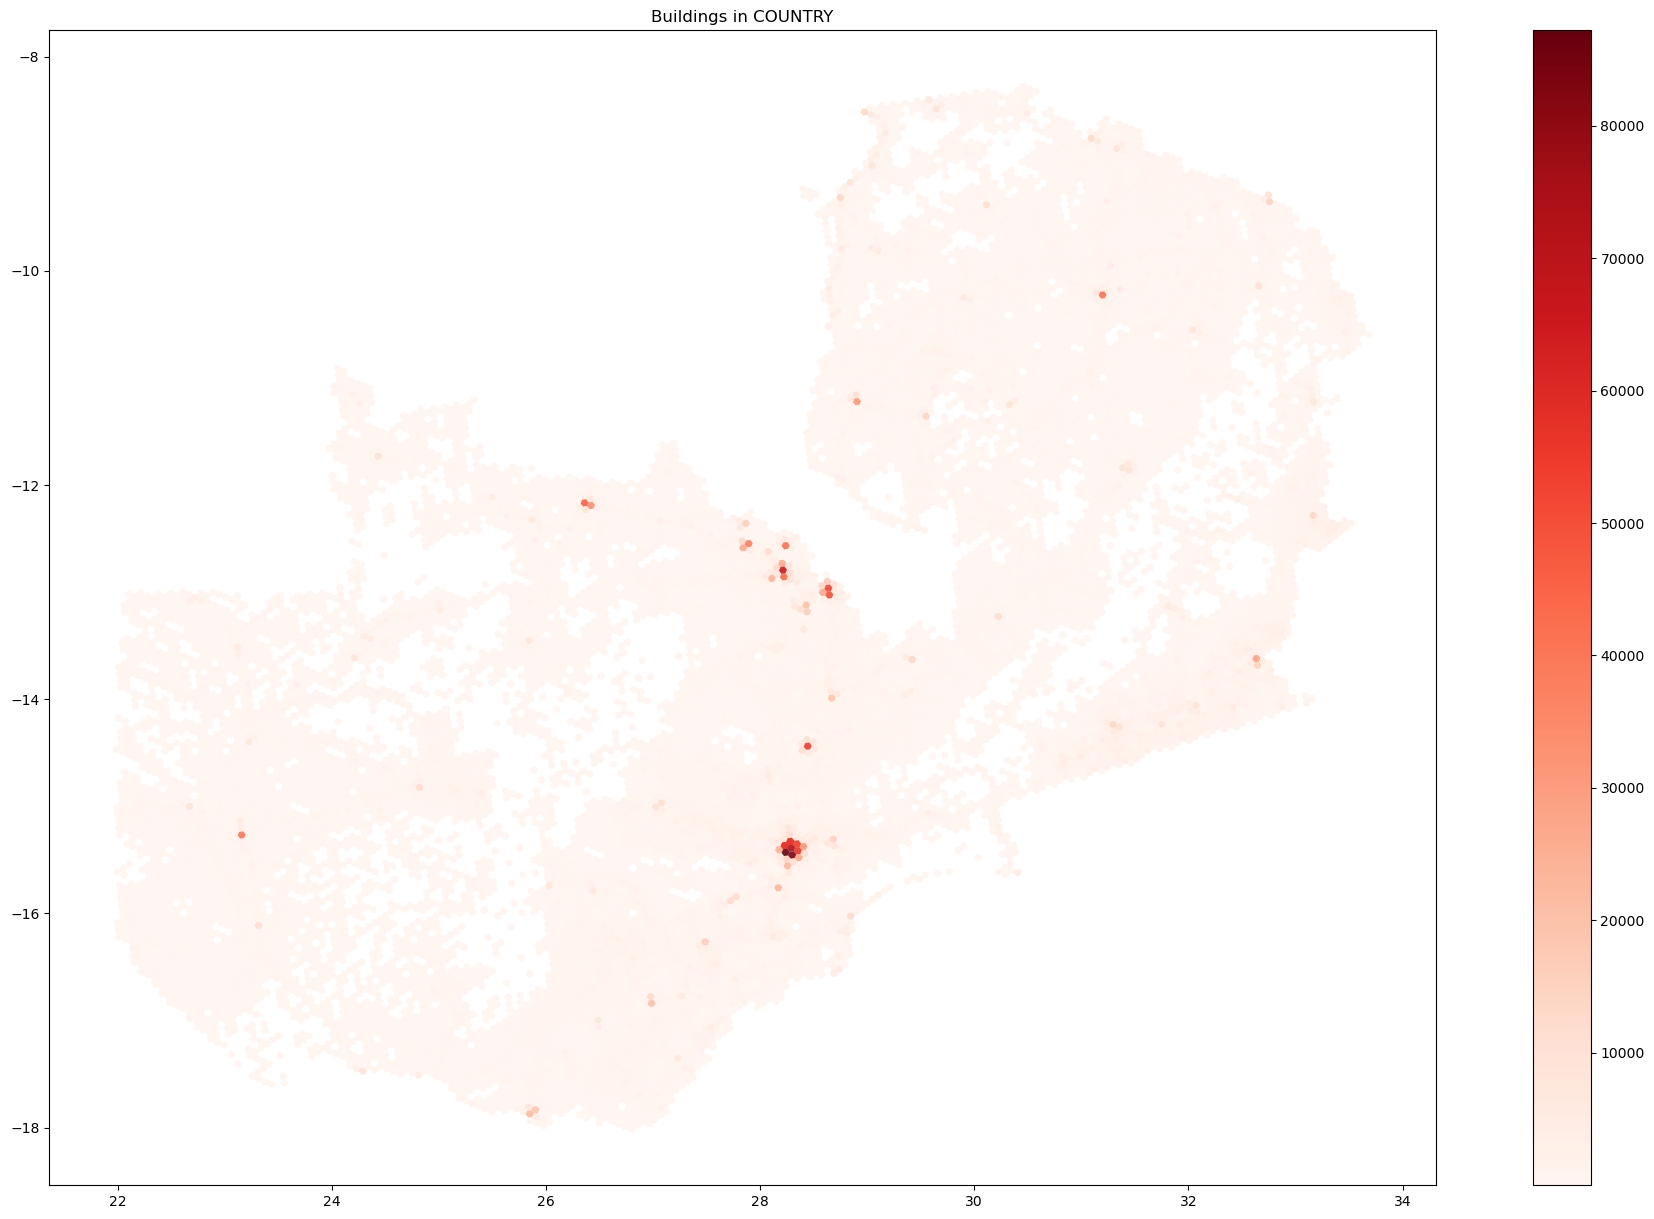

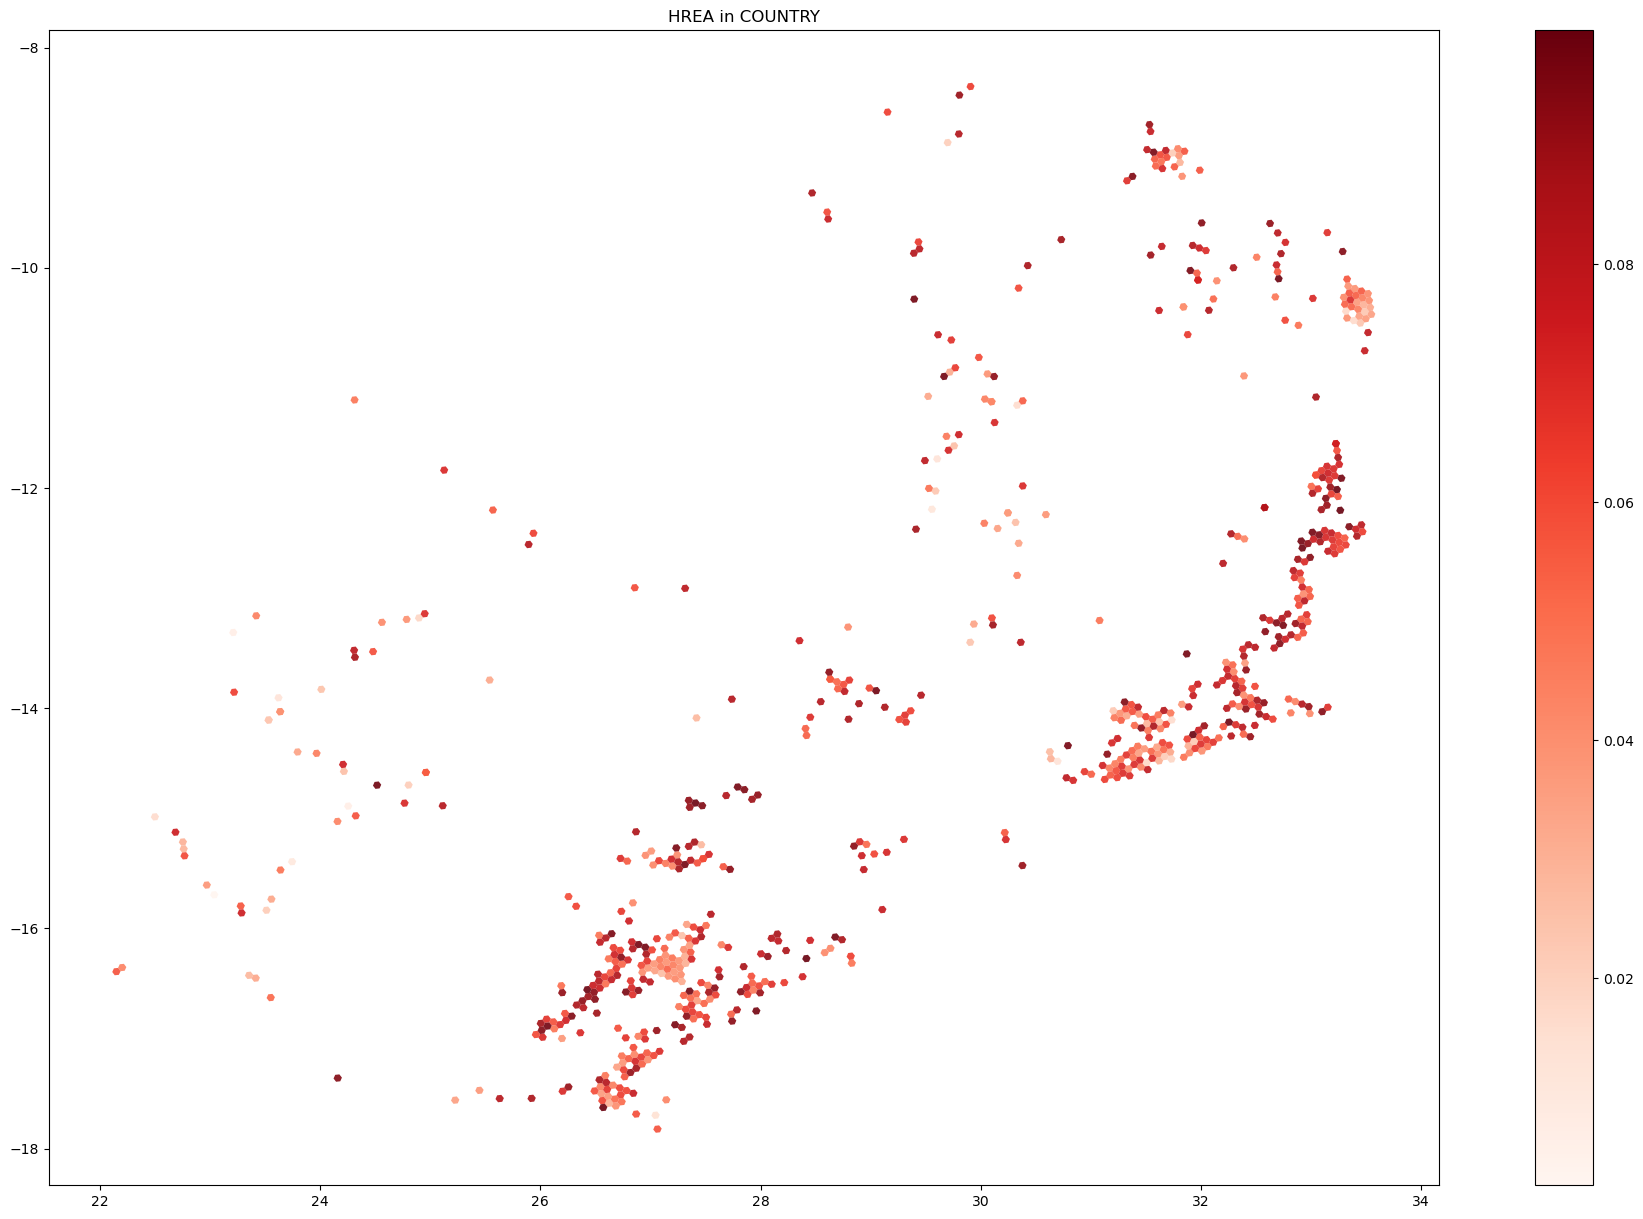

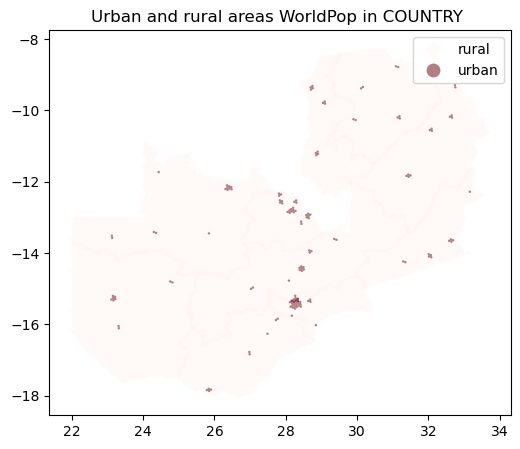

Total population: 17,798,700
Total population: 17,798,700
Total population with access: 9,301,438
Pop access rate : 52%
Pop access rate urban: 98%
Pop access rate rural: 22%
   Tier 1  Tier 2  Tier 3  Tier 4  Tier 5
0       8     200     778    2224    4656


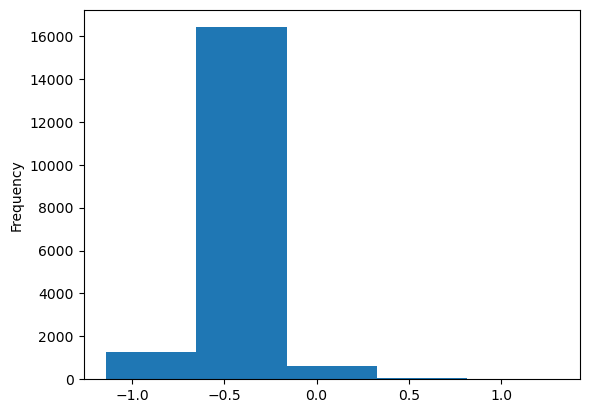

[(np.float64(-1.1399999856948853), 8), (np.float64(-0.651453317006429), 200), (np.float64(-0.16290664831797275), 778), (np.float64(0.32564002037048345), 2224), (np.float64(0.8141866890589398), 4656)]


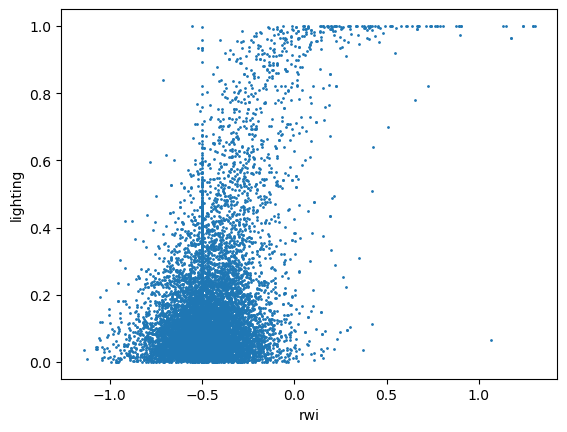

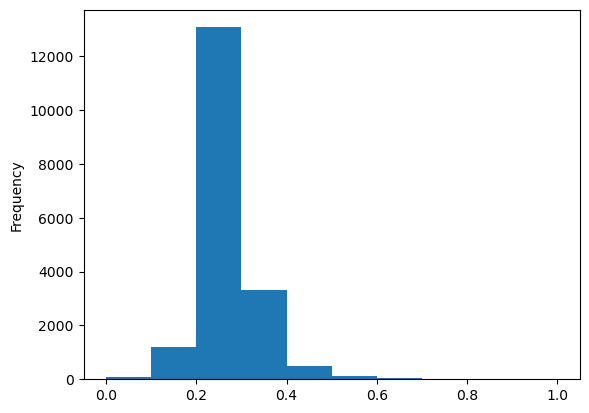

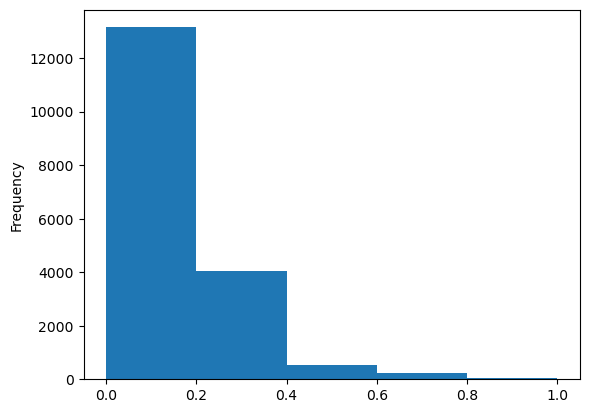

ResEnergyPerHH_index
8       13153
200      4037
778       525
4656      455
2224      220
Name: count, dtype: int64


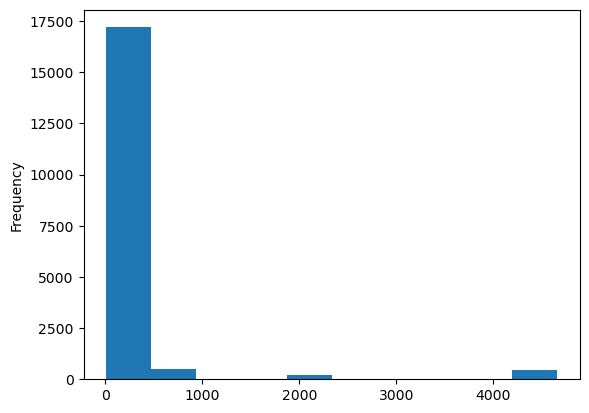

ResEnergyPerHH_index
8      0.01
200    0.05
778    0.06
2224   0.19
4656   0.24
0      0.46
Name: HHwithAccess, dtype: float64
ResEnergyPerHH_index
8      0.00
200    0.00
778    0.04
2224   0.38
4656   0.56
0      0.02
Name: HHwithAccess_urb, dtype: float64
ResEnergyPerHH_index
8      0.02
200    0.08
778    0.07
2224   0.05
4656   0.00
0      0.78
Name: HHwithAccess_rur, dtype: float64


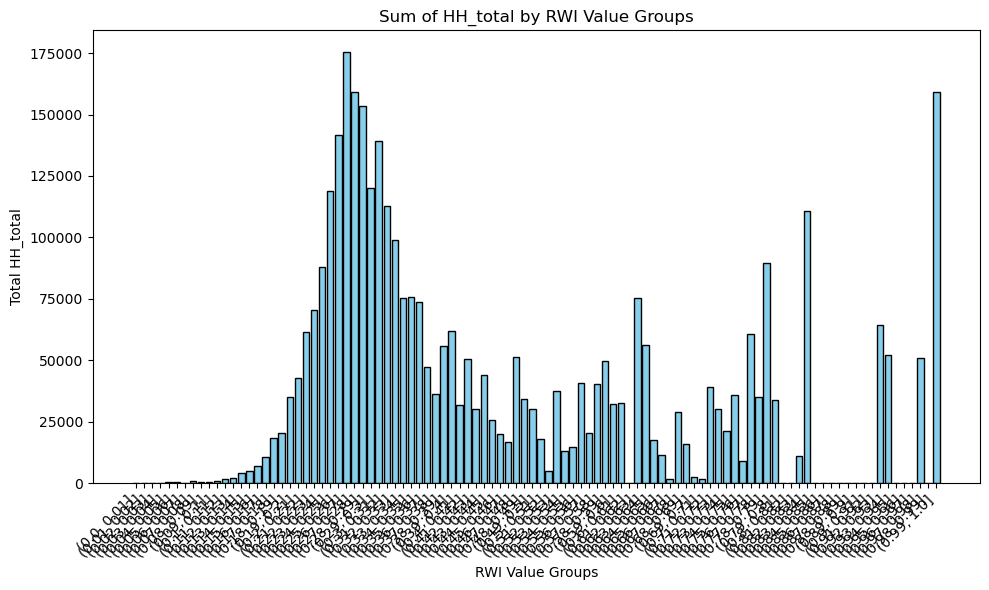

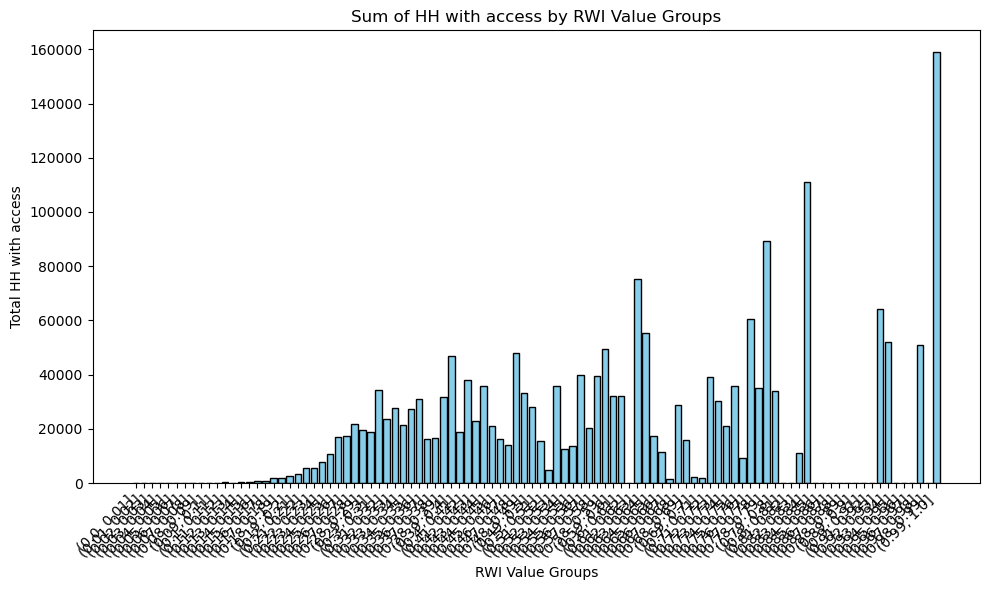

[12.04539519]


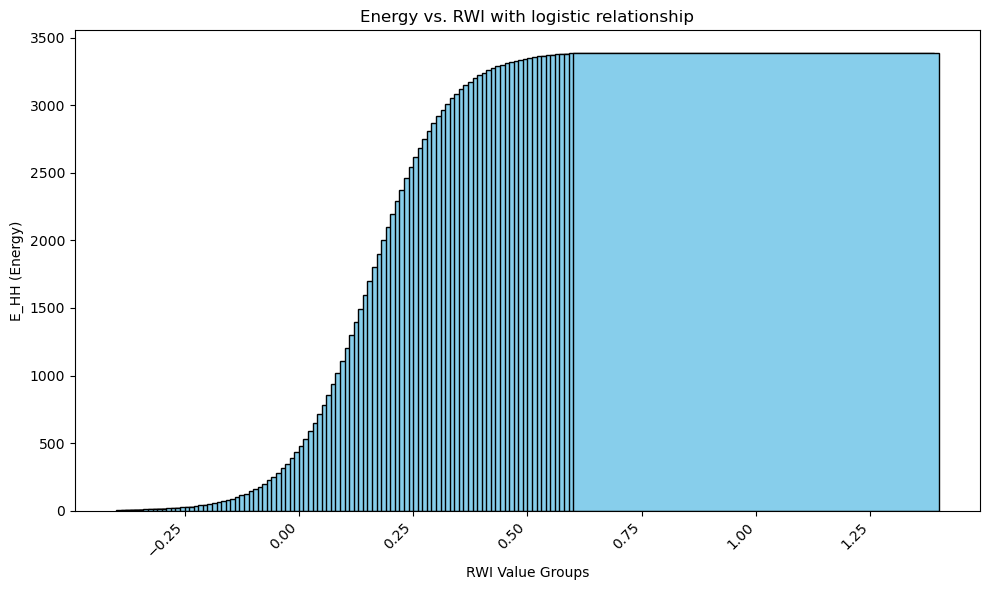

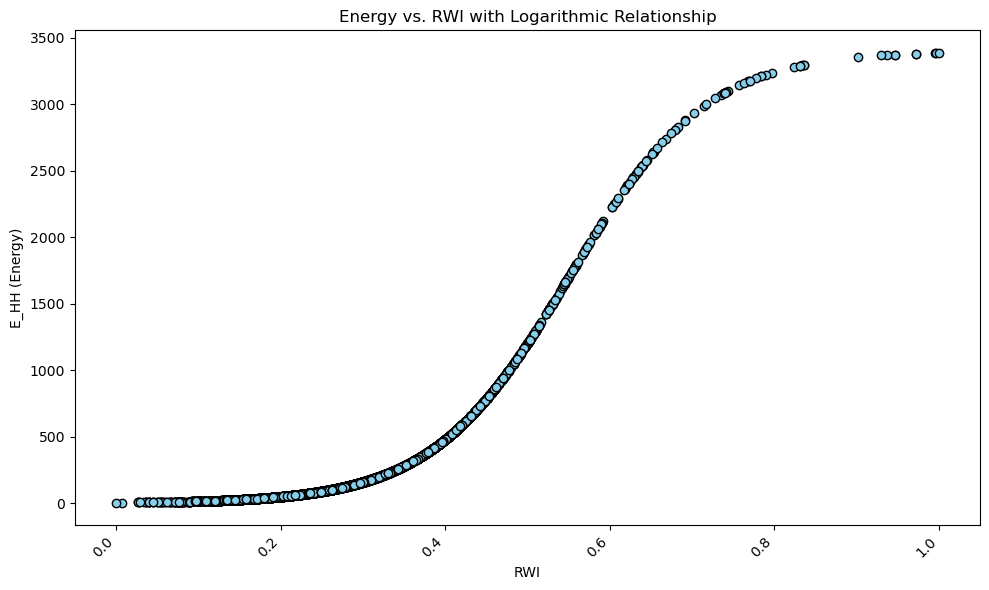

bin_labels
1   0.00
2   0.01
3   0.10
4   0.13
5   0.18
0   0.58
Name: HHwithAccess, dtype: float64
bin_labels
1   0.00
2   0.00
3   0.04
4   0.30
5   0.62
0   0.04
Name: HHwithAccess_urb, dtype: float64
bin_labels
1   0.00
2   0.01
3   0.13
4   0.07
5   0.02
0   0.78
Name: HHwithAccess_rur, dtype: float64
0.46943982624706726
Number of lines with similar values: 12394
Mean difference: 0.33762914627514956
Median difference: 0.0
Mode difference: 0   0.00
Name: Difference, dtype: float64
Index(['h3_index', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'index', 'index_righ',
       'NAME_1', 'id', 'buildingssum', 'locationWP', 'HREA', 'rwi', 'tiers',
       'GDP_PPP', 'geometry', 'Status_electrified', 'locWorldPop', 'location',
       'res_urbanBui', 'res_ruralBui', 'res_Bui', 'HH_urban', 'HH_rural',
       'HH_total', 'population', 'population_urban', 'population_rural',
       'population2', 'HHwithAccess_urb', 'HHwithAccess_rur', 'HHwithAccess',
       'HHwithAccess_urb_wostatus', 'HHwithAccess_r

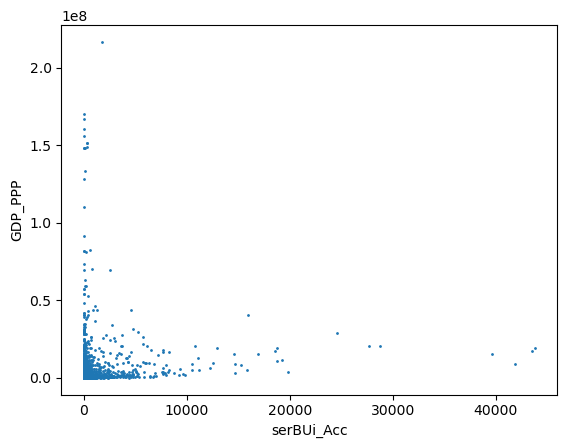

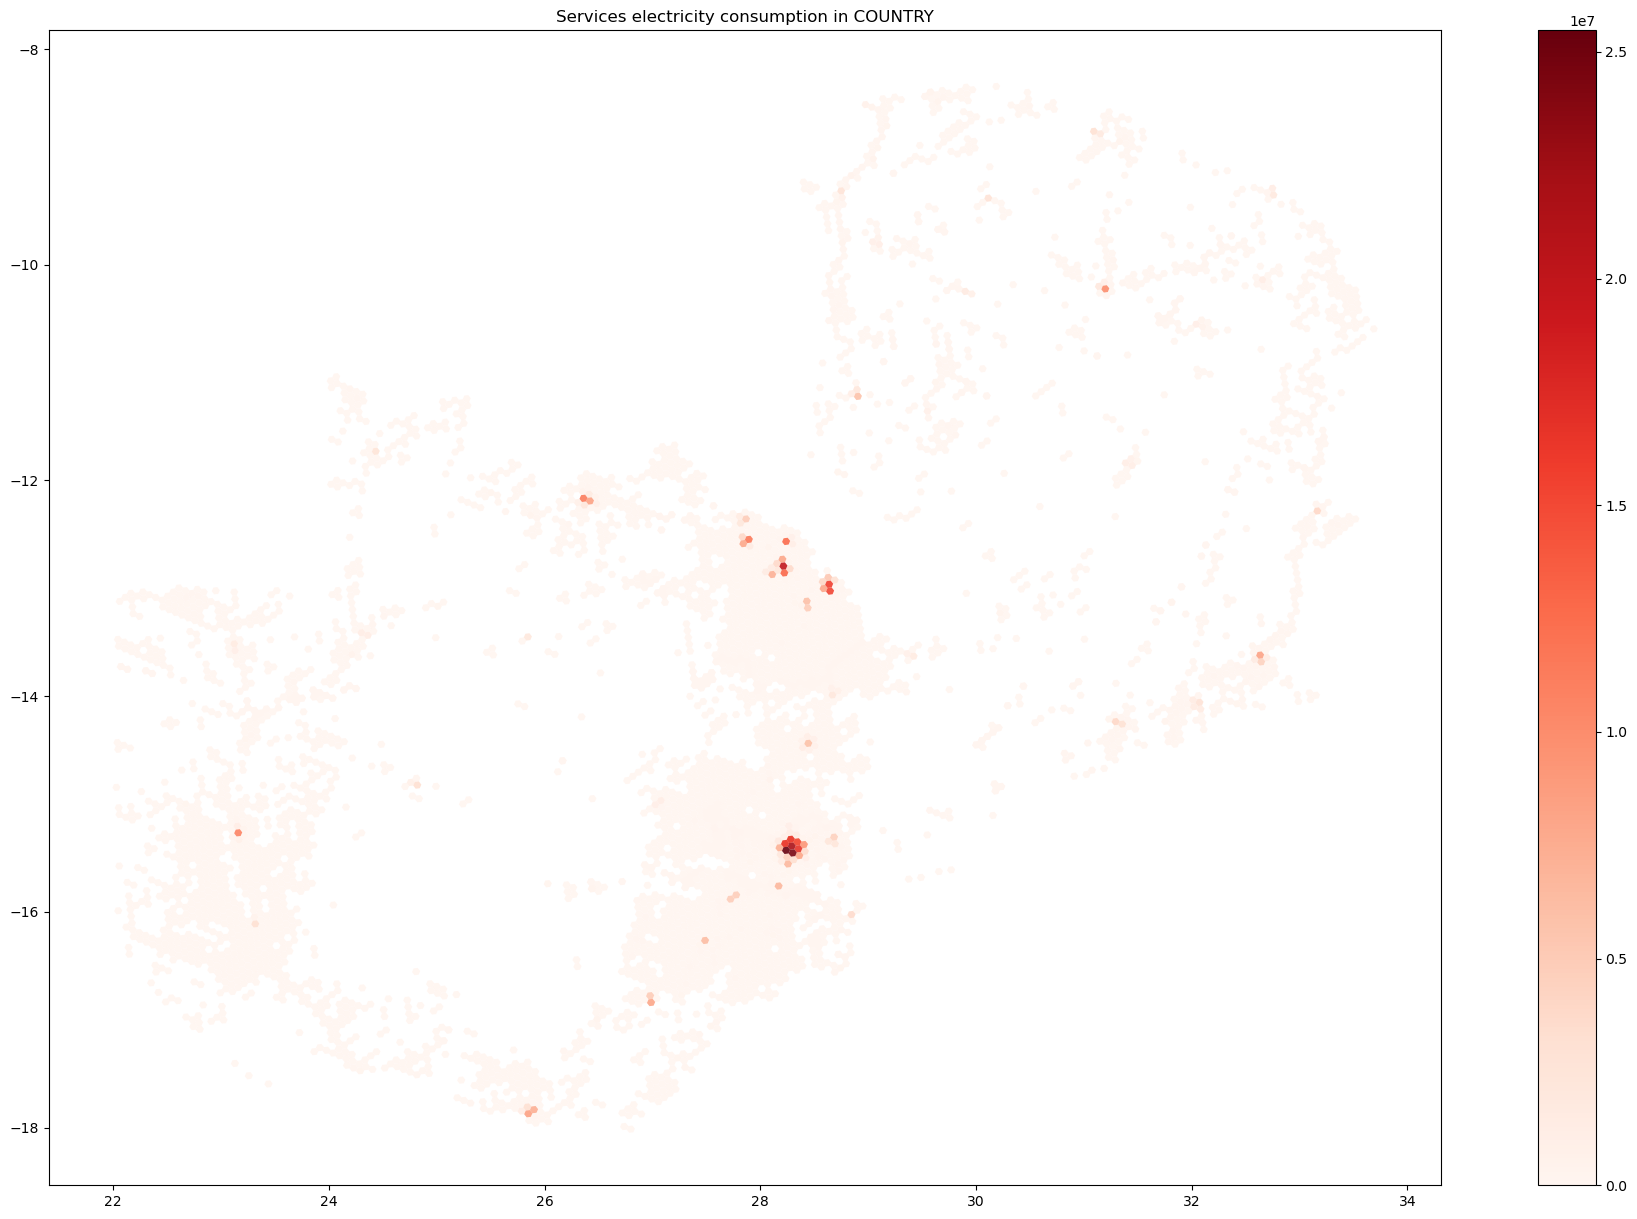

Services electricity consumption assessed after scaling:
Copperbelt 184.6 GWh
Muchinga 12.7 GWh
North-Western 42.8 GWh
Western 26.5 GWh
Luapula 28.5 GWh
Northern 29.1 GWh
Central 60.2 GWh
Southern 68.6 GWh
Eastern 47.1 GWh
Lusaka 221.7 GWh
NAME_1
Central          60.17
Copperbelt      184.60
Eastern          47.13
Luapula          28.47
Lusaka          221.65
Muchinga         12.67
North-Western    42.76
Northern         29.05
Southern         68.63
Western          26.53
Name: SEn_kWh_final, dtype: float64
721.6666666666665
Services electricity consumption assessed after scaling:
Copperbelt 1,439.5 GWh
Muchinga 31.8 GWh
North-Western 212.2 GWh
Western 104.4 GWh
Luapula 71.1 GWh
Northern 132.6 GWh
Central 301.8 GWh
Southern 333.7 GWh
Eastern 151.4 GWh
Lusaka 1,965.6 GWh
NAME_1
Central           301.82
Copperbelt      1,439.49
Eastern           151.40
Luapula            71.14
Lusaka          1,965.62
Muchinga           31.75
North-Western     212.17
Northern          132.58
Southern    

In [14]:
%run Residential/BuildingDemandMethod1_Simplified.ipynb


In [15]:
total_residentialenergy_assessed = grid['ResEnergy_kWh_meth3'].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

residential electricity consumption: 2,850 GWh


In [16]:
# grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*50 if ((row['buildingscount'] > 100))
                                             # else row['buildingscount']*100), axis=1)
# total_servicesenergy_assessed = grid["Commercial"].sum()
# print("services electricity consumption:", f"{total_servicesenergy_assessed/10**6:,.0f}","GWh") # GWh

In [17]:
%run Industry/IndustryDemand.ipynb
print("Industry electricity consumption in",f"{area}",f"{total_industryenergy/3600:,.1f}", "TWh")

Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mkushi Heap Leach  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mufulira West Heap-Leach Facility  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  TD3a, TD3b, TD5, and TD7 Tailings Dams  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
total statistical electricity consumption of nonFerrousMetals: 22,897.0 TJ
total statistical electricity consumption in mining: 818.0 TJ
total statistical electricity consumption of nonFerrousMetals and mining: 23,715.0 TJ
total statistical oil consumption o

In [6]:
#Concatenate results
out_path = ROOT_DIR + "/Outputs/"
# gridRes = gpd.read_file(out_path + "res_energy_map.shp")
# gridRes = gpd.read_file(out_path + "ser_energy_map.shp") # contains services and residential data
gridBui = gpd.read_file(out_path + "ser_energy_map.geojson") # contains services and residential data
# gridRes = gridRes.to_crs(crs_proj)
# gridInd = gpd.read_file(out_path + "ind_energy_map.shp")
gridInd = gpd.read_file(out_path + "ind_energy_map.geojson")
# gridInd = gridInd.to_crs(crs_proj)
# init
grid = gridBui.copy()
grid = grid.merge(gridInd, on='id', suffixes=('', '_y'))
# grid = gpd.GeoDataFrame(grid,crs=crs_proj, geometry=grid.geometry)
grid.drop(grid.filter(regex='_y$').columns, axis=1, inplace=True)
# grid = gpd.pd.concat([gridRes, gridInd])
grid.head(4)

h3_index     n0     n1     n2    n3     n4     n5  index  \
0  8696ad067ffffff   1642  12461   1256  9536   9610   5890   0.25   
1  86961888fffffff   9642   8609   9458  5868      0      0   0.60   
2  86961010fffffff   8372  12794  13810  3970   9962   2556   0.14   
3  86962e1a7ffffff  14188    945   8473  8920  14978  16346   0.41   

   index_righ    NAME_1  ...   nb_men  nb_women_working  nb_men_working  \
0           7  Northern  ...    37.19              5.39            6.59   
1           3   Luapula  ... 1,330.10            238.17          244.34   
2           5  Muchinga  ...      NaN               NaN             NaN   
3           4    Lusaka  ...   181.93             39.35           78.41   

   total_employee  SEn_kWh_Emp  SEn_kWh_weighted  SEn_kWh_final  \
0           11.98     3,252.32               NaN            NaN   
1          482.51   131,005.86        131,005.86     160,661.34   
2             NaN          NaN               NaN            NaN   
3          117.76    31,971.81         31,971.81      39,209.19   

                                            geometry Energy Elec [TJ]  \
0  POLYGON ((30.28824 -9.29376, 30.2514 -9.29894,...              NaN   
1  POLYGON ((28.70087 -10.44444, 28.66381 -10.449...              NaN   
2  POLYGON ((31.57451 -11.45629, 31.53742 -11.461...              NaN   
3  POLYGON ((27.89502 -15.31325, 27.85721 -15.318...              NaN   

  IndEne_TJ  
0       NaN  
1       NaN  
2       NaN  
3       NaN  

[4 rows x 77 columns]

In [7]:
# grid.columns

In [8]:
#Unit
grid["IndEnergy_GWh"]=grid["IndEne_TJ"]/3600 *10**3
total_ind = grid["IndEnergy_GWh"].sum()
print(f"{total_ind:,.0f}", "GWh")
grid['REnS_GWh'] = grid['ResEnergy_kWh_meth3']/10**6
total_res = grid["REnS_GWh"].sum()
print(f"{total_res:,.0f}", "GWh")
grid['SEn_GWh'] = grid['SEn_kWh_final']/10**6
total_ser = grid["SEn_GWh"].sum()
print(f"{total_ser:,.0f}", "GWh")

5,229 GWh
2,850 GWh
722 GWh


In [9]:
grid["TotalDem"] = grid.apply(lambda row: (np.nansum([row['REnS_GWh'], 
                                          row['SEn_GWh'],  
                                             row["IndEnergy_GWh"]
                                                     ])), axis=1) #sum in GWh

In [10]:
total = grid["TotalDem"].sum()
print("total electricity consumption:", f"{total:,.0f}","GWh") # GWh

total electricity consumption: 8,800 GWh


In [11]:
grid.head(3)

h3_index    n0     n1     n2    n3    n4    n5  index  index_righ  \
0  8696ad067ffffff  1642  12461   1256  9536  9610  5890   0.25           7   
1  86961888fffffff  9642   8609   9458  5868     0     0   0.60           3   
2  86961010fffffff  8372  12794  13810  3970  9962  2556   0.14           5   

     NAME_1  ...  SEn_kWh_Emp  SEn_kWh_weighted  SEn_kWh_final  \
0  Northern  ...     3,252.32               NaN            NaN   
1   Luapula  ...   131,005.86        131,005.86     160,661.34   
2  Muchinga  ...          NaN               NaN            NaN   

                                            geometry  Energy Elec [TJ]  \
0  POLYGON ((30.28824 -9.29376, 30.2514 -9.29894,...               NaN   
1  POLYGON ((28.70087 -10.44444, 28.66381 -10.449...               NaN   
2  POLYGON ((31.57451 -11.45629, 31.53742 -11.461...               NaN   

   IndEne_TJ  IndEnergy_GWh REnS_GWh SEn_GWh TotalDem  
0        NaN            NaN     0.00     NaN     0.00  
1        NaN            NaN     0.01    0.16     0.17  
2        NaN            NaN      NaN     NaN     0.00  

[3 rows x 81 columns]

### Export result

In [12]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [13]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + 'total_demand_grid.geojson', driver="GeoJSON")
grid.to_file(out_path + f'total_demand.geojson', driver='GeoJSON', index=False)  

## Print maps for quick assessment

In [14]:
plt.rcParams.update({'font.size': 22})

### Total demand map

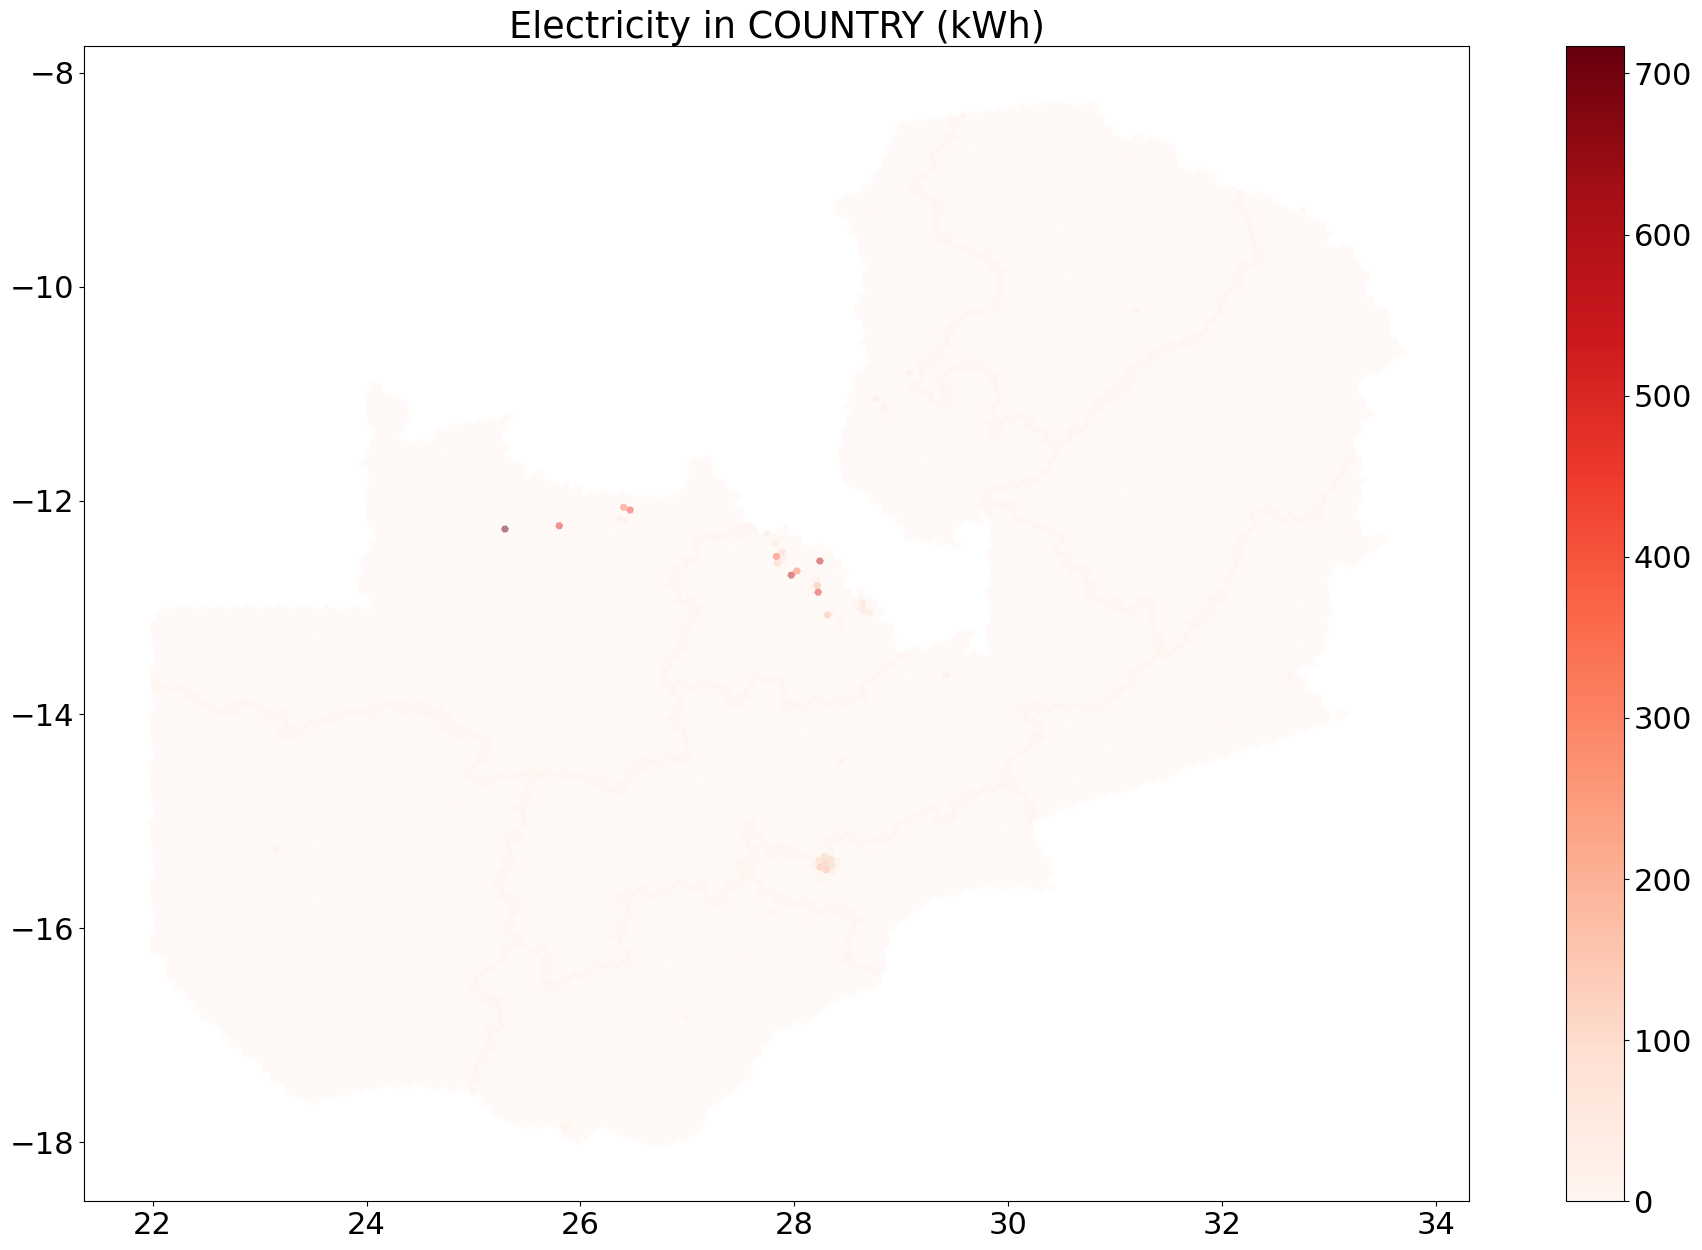

In [15]:
# Plot the demand map with use of the full scale
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig(out_path +'sample_priority_map.png', bbox_inches='tight')

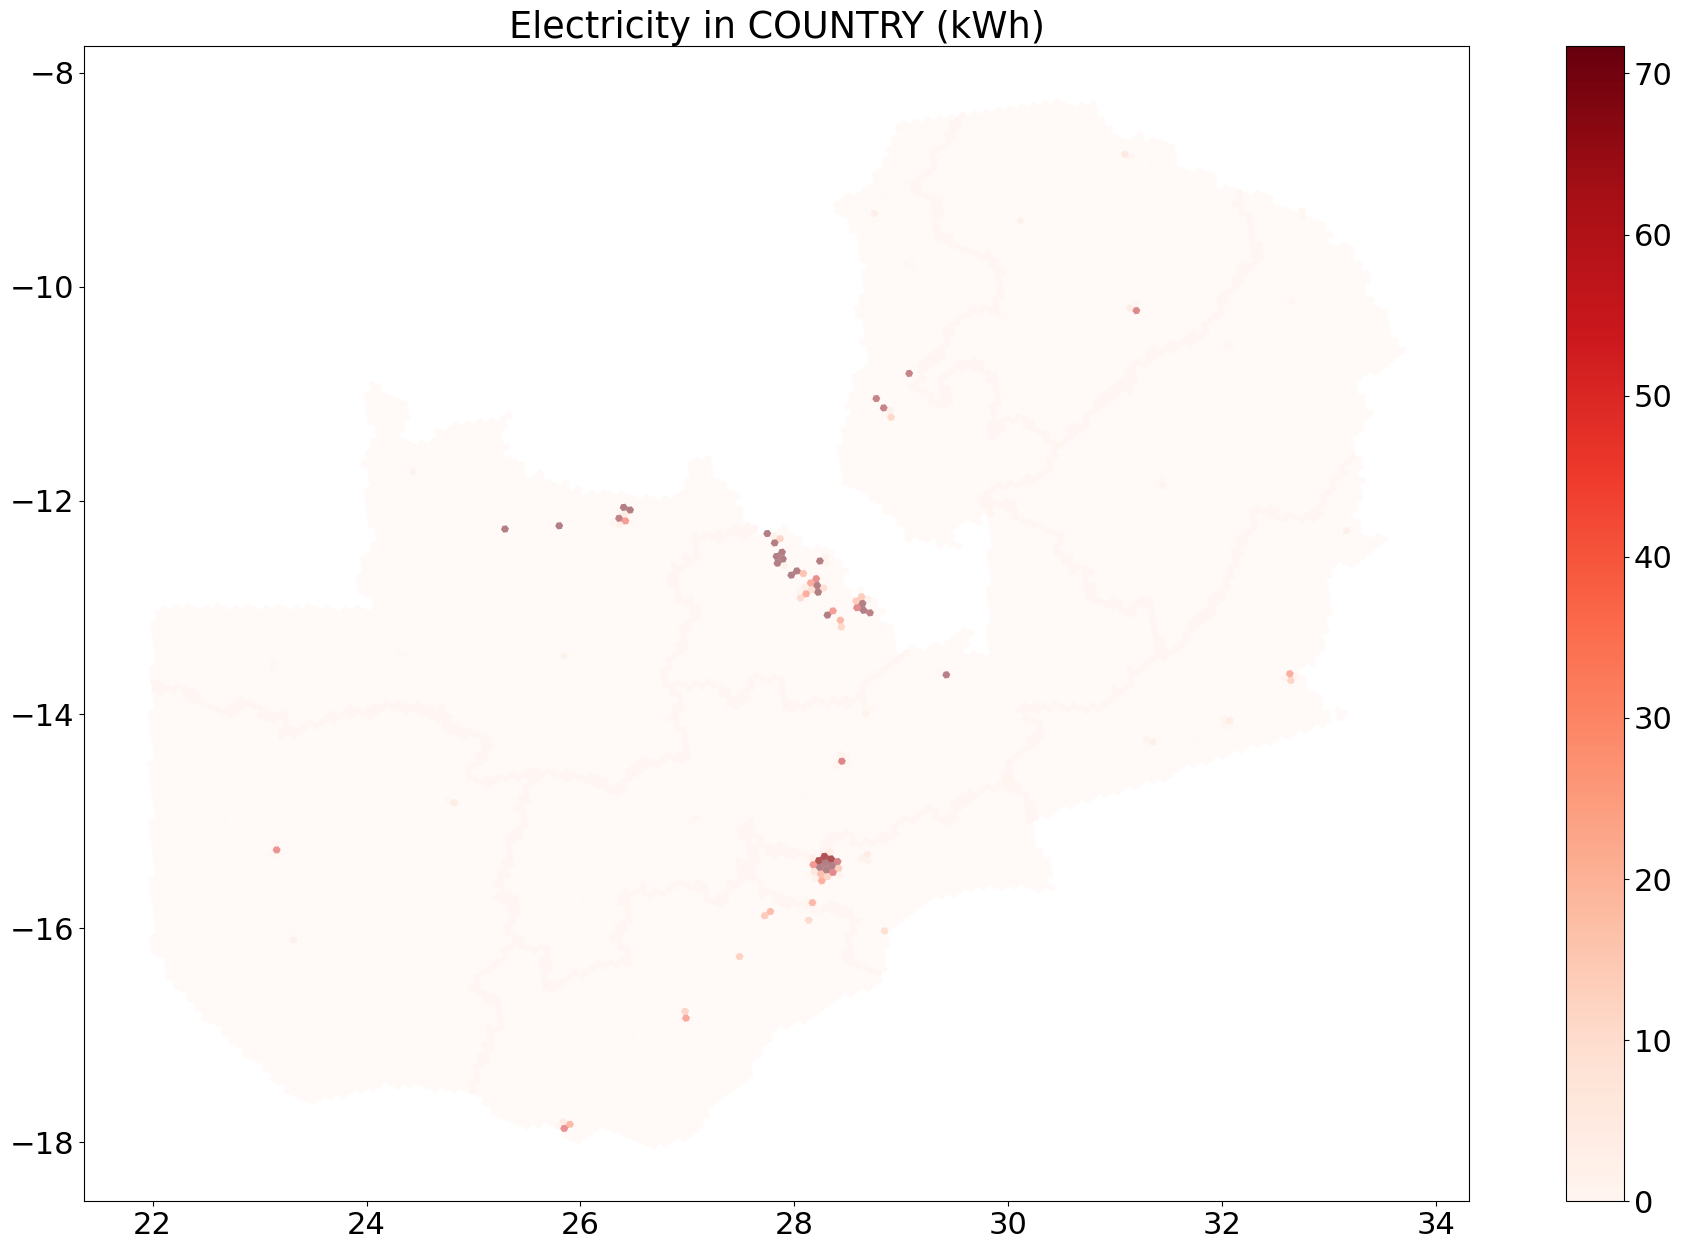

In [16]:
# Plot the demand map with a threshold value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Set the threshold
# threshold = np.percentile(npgrid['TotalDem'], 90)
threshold = 0.1 * grid['TotalDem'].max()

# Plot data
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig(out_path +'sample_priority_map_threshold.png', bbox_inches='tight')

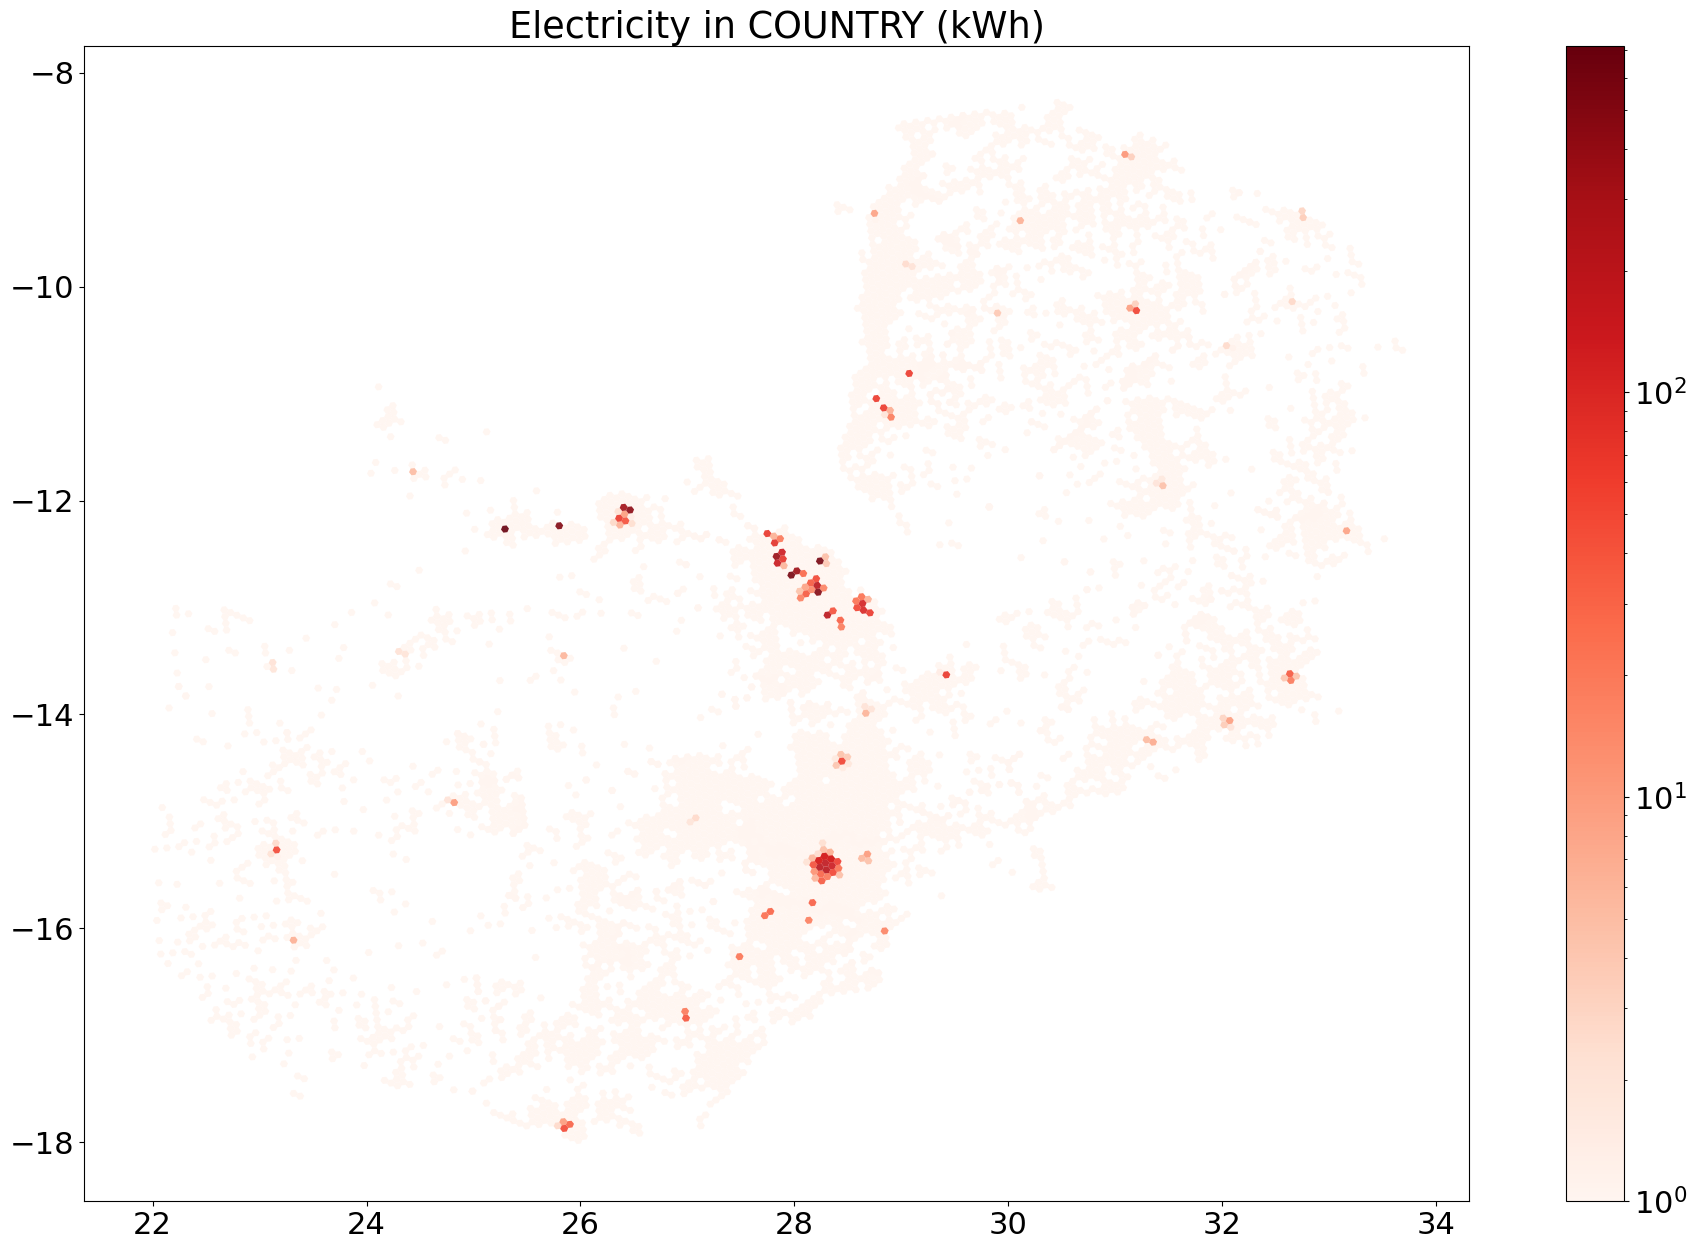

In [17]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['TotalDem'].max()))

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig(out_path +'sample_priority_map_log.png', bbox_inches='tight')

### Residential map

NameError: name 'admin_gdf' is not defined

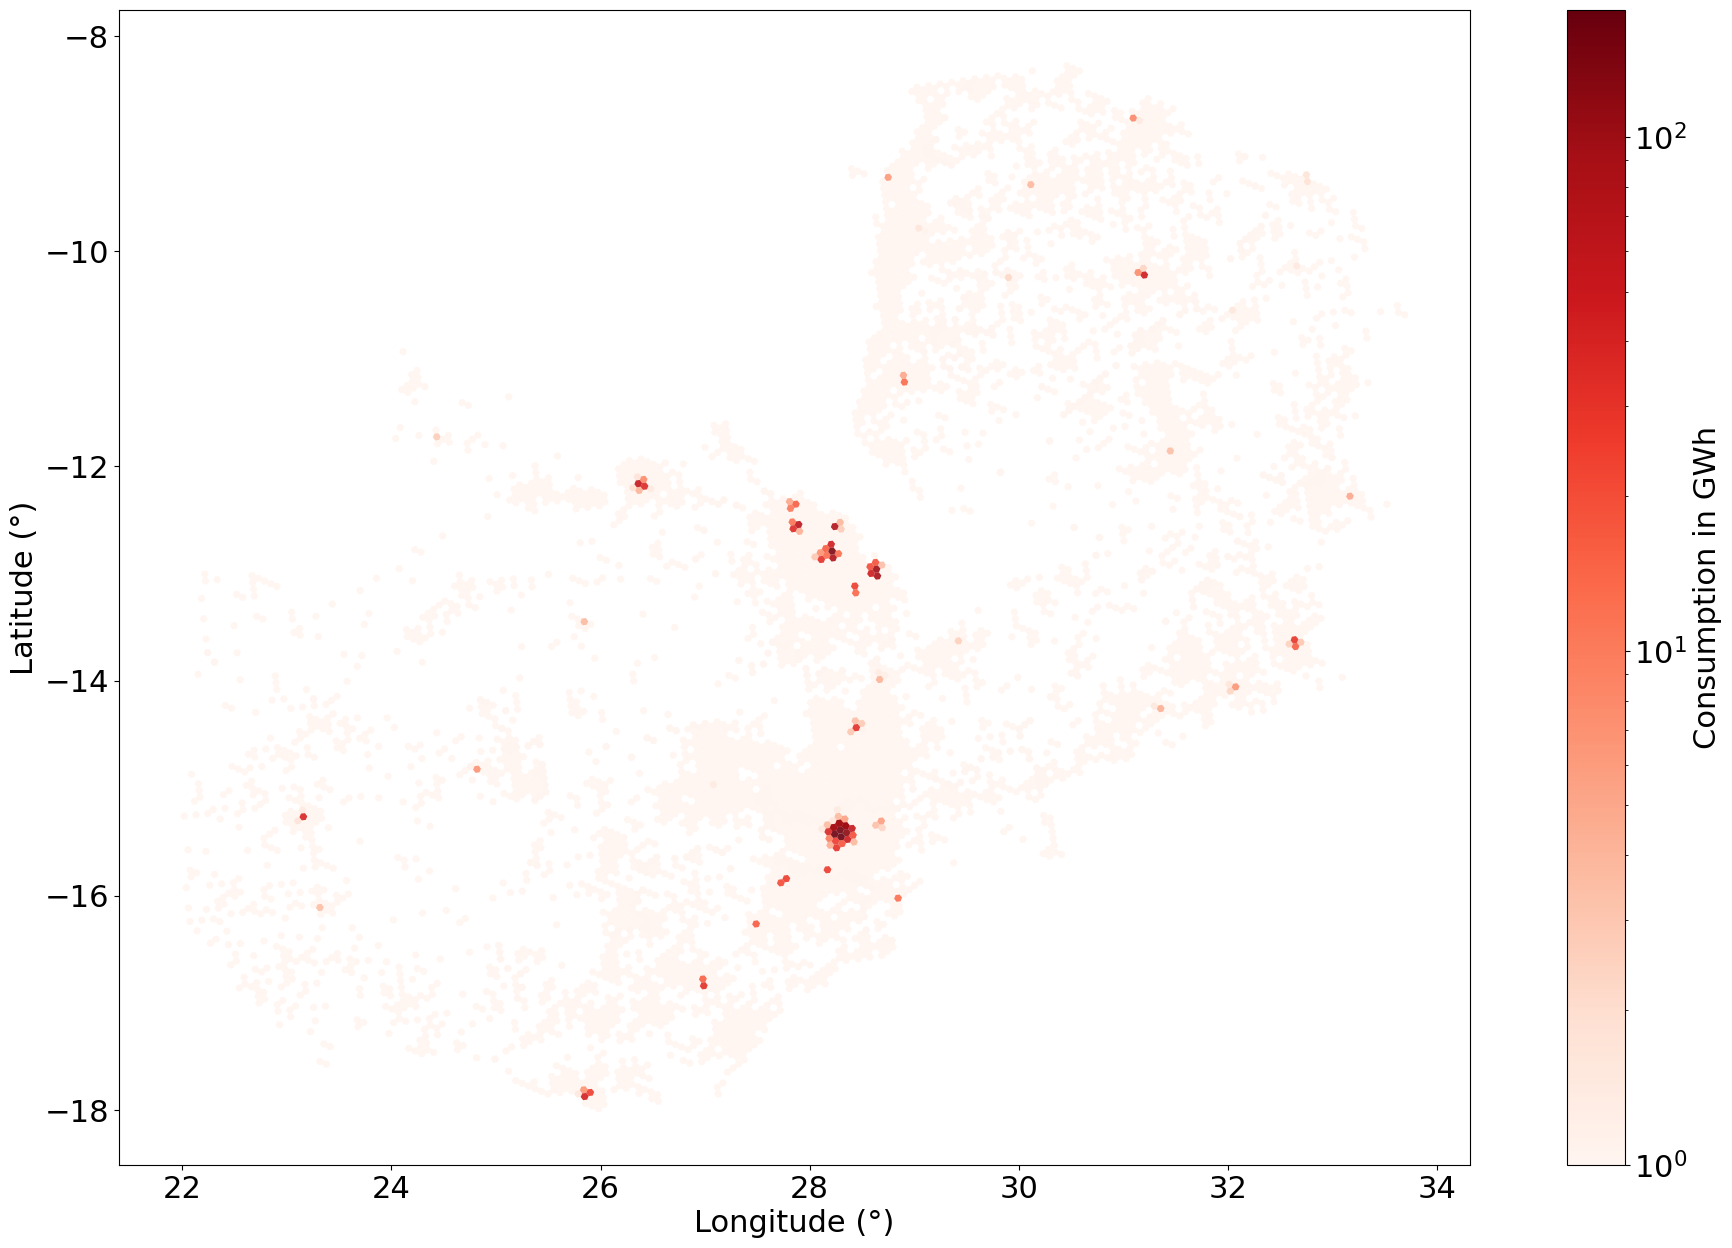

In [18]:
# Plot the demand map with a log scale value
# Create the axis first
# sns.set_theme('poster')
# sns.set_style('white')
fig, ax = plt.subplots(figsize=(25, 15))

# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Plot data
grid.sort_values('REnS_GWh', ascending=True).plot(
    ax=ax, column='REnS_GWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['REnS_GWh'].max()),
    legend_kwds={"label": "Consumption in GWh"}) #, "orientation": "horizontal"})

admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.4)
# MV_lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.05)

ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity consumption in the residential sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity consumption in the residential sector (kWh)' )

# print(grid.crs)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(out_path +'map_residential_log.png', bbox_inches='tight')

### Services map

In [ ]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')


# Plot data
grid.sort_values('SEn_GWh', ascending=True).plot(
    ax=ax, column='SEn_GWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['SEn_GWh'].max()),
    legend_kwds={"label": "Consumption in GWh"})
admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.4)

# # Plot data
# grid.sort_values('TotalDem', ascending=True).plot(
#     ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('TotalDem', ascending=True).plot(
#     ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.9)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)
ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in the services sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity in the services sector (GWh)')

ax.add_artist(scalebar)
# Save plot as figure 
plt.savefig(out_path +'map_services_log.png', bbox_inches='tight')

### Buildings map

In [ ]:
grid['Bui_GWh'] = grid['SEn_GWh']+grid['REnS_GWh']

In [ ]:
# Plot the demand map with a log scale value
# Create the axis first
sns.set_theme('poster')
fig, ax = plt.subplots(figsize=(25, 15))
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')


# Plot data
grid.sort_values('Bui_GWh', ascending=True).plot(
    ax=ax, column='Bui_GWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['Bui_GWh'].max()),
    legend_kwds={"label": "Consumption in GWh"})
admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.4)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)
ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in buildings in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity in buildings (GWh)')

ax.add_artist(scalebar)
# Save plot as figure 
plt.savefig(out_path +'map_buildings_log.png', bbox_inches='tight')

### Industry map

In [ ]:
# Plot the industry demand map per cell
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data with a log scale value
grid.sort_values('IndEnergy_GWh', ascending=True).plot(
    ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['IndEnergy_GWh'].max()),
    legend_kwds={"label": "Consumption in GWh"})

# # Plot data
# grid.sort_values('IndEnergy_GWh', ascending=True).plot(
#     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('IndEnergy_GWh', ascending=True).plot(
#     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.9)

admin_gdf.plot(ax=ax, color='None', edgecolor='brown', alpha=0.1)
lines_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in the mining sector in {} (GWh)'.format(area) )

# Save plot as figure 
plt.savefig(out_path +'map_industry_log.png', bbox_inches='tight')

In [ ]:
(grid['IndEnergy_GWh'] != 0).sum()

In [ ]:
(grid['IndEnergy_GWh'] > 50).sum()

In [ ]:
totalperregion=grid.groupby('NAME_1')['IndEnergy_GWh'].sum()
totalperregion

In [ ]:
grid['totalindeperregion'] = grid['NAME_1'].map(totalperregion)

In [ ]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('totalindeperregion', ascending=True).plot(
    ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['totalindeperregion'].max()))

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.05)
ax.set_aspect('equal', 'box')
ax.set_title('Electricity in the mining sector in Zambia (GWh)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

from matplotlib.ticker import FuncFormatter

# fmt = lambda x, pos: '{:.1%}'.format(x)
# cbar = plt.colorbar(format=FuncFormatter(fmt))

# Save plot as figure 
plt.savefig(out_path +'map_log_ind.png', bbox_inches='tight')